In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import random
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [3]:
questions_df = pd.read_csv('question-pairs-dataset/questions.csv')     #reading questions from questions.csv
questions_data = list(questions_df['question1'])                       #taking only the column of questions
questions_data = questions_data[:10664]                                #taking a slice as the other dataset has only 10664 entries

In [4]:
with open('positive-and-negative-sentences/positive.txt','rb') as file:
    data_pos = file.read().decode(errors='replace')     #positive comments
data_pos = data_pos.split('\n')                         #split based on new line
with open('positive-and-negative-sentences/negative.txt','rb') as file:
    data_neg = file.read().decode(errors='replace')     #negative comments
data_neg = data_neg.split('\n')                         #split based on new line

In [5]:
non_questions_data = data_pos+data_neg                  #combine
random.shuffle(non_questions_data)                      #shuffle

In [6]:
questions_data_labels = list(np.ones(len(questions_data)))                  #target vectors for question and non question data
non_questions_data_labels = list(np.zeros(len(non_questions_data)))

In [7]:
X = questions_data + non_questions_data
Y = questions_data_labels + non_questions_data_labels
X,Y = shuffle(X,Y,random_state=1)                      #shuffling X and Y 



In [8]:
X = np.array(X)
Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=31) #split testing and training set
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 19195
# Test data samples: 2133


In [9]:
tk = Tokenizer(num_words=NB_WORDS,                            #defining tokenizer which tokenizes sentences into
               filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n', #words. Note that we do not filter out ''?'.
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)                  #convert texts to sequences(based on incices)
X_test_seq = tk.texts_to_sequences(X_test)


In [10]:
seq_lengths = pd.Series(X_train).apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

#We check what is the maximum length of sequence, so that we can pad zeros for the rest sequences, as the input length has to be constant

count    19195.000000
mean        16.600990
std          9.613699
min          1.000000
25%          9.000000
50%         14.000000
75%         23.000000
max         66.000000
dtype: float64

In [11]:
MAX_LEN = 44  # Maximum number of words in a sequence. We truncate if more than this.

In [12]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)   #pad zeros
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [13]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0, 1144,   54, 1021,    4,   54, 1653, 2867,
       1561,   39,    1, 4402,  184,   18,  131,  157,    5,  121,   67,
         61,   40,  132,  182,   22,    1,   27,   42,   43,   45,  360,
        786,   10,   61, 4403,   22,   10,   85,   18,   36, 2241,  708],
      dtype=int32)

In [14]:
print(y_train)   #example of label

[0. 0. 0. ... 0. 1. 1.]


In [15]:
le = LabelEncoder()
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [16]:
print(y_train_oh)   #example of label after one hot encoding

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [17]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

#separating validation set from training set

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

#checking if dimensions are same for training and testing shape

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1920, 44)


In [18]:
#Some functions needed later

def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results


In [19]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'    #glove file containing words and glove vectors
emb_dict = {}
glove = open('glove.twitter.27B/'+ glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

#Constructing embedding mastrix

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [20]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
#glove_model.add(layers.Flatten())
#glove_model.add(layers.Dense(1000,activation='tanh'))          #found that hidden layer results in overfitting
glove_model.add(layers.LSTM(200, dropout_U = 0.2, dropout_W = 0.2))
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/mayank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  """


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 44, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 1,241,202
Trainable params: 1,241,202
Non-trainable params: 0
_________________________________________________________________


In [21]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False             #we are using pretrained weights. No need to train the initial layer

In [22]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)   #TRAINING THE MODEL
glove_history.history['acc'][-1]

Instructions for updating:
Use tf.cast instead.


0.979681621474226

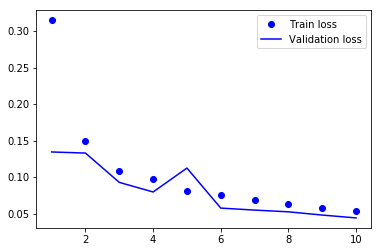

In [23]:
eval_metric(glove_history, 'loss')                    #Loss during traning vs validation

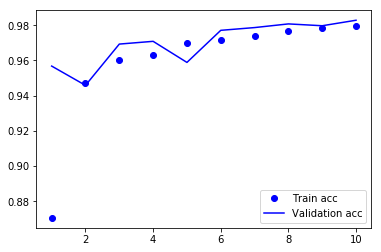

In [24]:
eval_metric(glove_history, 'acc')                     #Accuracy during traning vs validation


In [25]:

glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3) #test on test dataset
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

2133/2133 [==============================] - 1s 678us/step
/n
Test accuracy of word glove model: 98.08%


In [26]:
def predict_if_question(sentence):
    sentence_nstop = [sentence]
    sentence_nstop = np.array(sentence_nstop)
    sentence_seq = tk.texts_to_sequences(sentence_nstop)
    print(sentence_seq)
    sentence_seq_trunc = pad_sequences(sentence_seq, maxlen=MAX_LEN)
    return glove_model.predict(sentence_seq_trunc)

In [27]:
predict_if_question("You are going to the park arent you")

[[18, 14, 182, 5, 1, 2608, 18]]


array([[0.0728917 , 0.92710835]], dtype=float32)

In [28]:
predict_if_question("Do you?")

[[15, 671]]


array([[0.03219453, 0.9678055 ]], dtype=float32)

In [29]:
predict_if_question("explain about telecom industry")

[[1963, 40, 1094]]


array([[0.4456844 , 0.55431557]], dtype=float32)

In [30]:
predict_if_question("i was explaining about telecom industry")

[[9, 78, 8862, 40, 1094]]


array([[0.8016843 , 0.19831575]], dtype=float32)